# M19 Analítica operaciones

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Ignoramos warnings de seaborn
import warnings
warnings.filterwarnings("ignore")

from IPython.display import clear_output

from sklearn.model_selection import train_test_split

## Lectura de datos

Leemos los datos del dataset y mostramos las primeras filas.

In [10]:
fraud_data = pd.read_csv("data/FraudInputDatav2.csv", encoding="utf-16")
fraud_data.head()

,ID,Age_Account,Age_Bill,N1NameEqual,NameCityEqual,Payment,Value,Credit,Channel,Product,...,N5_Accounts_Card,N5_Devices_Account,N5_Names_Account,N5_CEP_Account,N5_Cards_Account,N5_Cards_Device,Fraud,random,sample,FraudStr
0,1,0.445878,-0.359697,0,0,credit_card,-0.258301,0,CD,F,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0.027303,train,Good
1,2,-0.782197,-0.632741,0,0,credit_card,-0.258301,0,CE,F,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0.028333,train,Good
2,3,0.298404,0.927510,0,0,credit_card,-0.275540,0,CD,CB,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0.008819,check,Good
3,4,-0.664740,2.472159,0,0,credit_card,-0.274538,1,CE,CB,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0.038630,train,Good
4,5,-0.223625,-0.617138,0,0,credit_card,-0.218079,0,CD,CA,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0.000657,train,Good


A la vista de las variables vamos a eliminar las siguientes variables:

* `FraudStr` Contiene la misma información que `Fraud` pero en formato string.
* `sample` Contiene la partición en sets.
* `random` Continene un número aleatorio.

In [11]:
fraud_data = fraud_data.drop(['FraudStr', 'sample', 'random'], axis = 1)

## Análisis exploratorio

Antes de nada vamos a comprobar el número de observaciones y de variables que tenemos.

In [12]:
n_rows, n_cols = fraud_data.shape
print(f"El dataset tiene {n_rows} observaciones y {n_cols} variables.")

El dataset tiene 62763 observaciones y 71 variables.


Creamos un DataFrame con la descripción de cada columna

In [13]:
column_description = pd.DataFrame({
    "column": fraud_data.columns,
    "dtype": fraud_data.dtypes,
    "unique": fraud_data.apply(lambda c: c.unique().size, axis = 0),
    "na_count": fraud_data.apply(lambda c: c.isna().sum(), axis = 0),
})
column_description.head()

,column,dtype,unique,na_count
ID,ID,int64,62763,0
Age_Account,Age_Account,float64,3105,0
Age_Bill,Age_Bill,float64,1005,0
N1NameEqual,N1NameEqual,int64,2,0
NameCityEqual,NameCityEqual,int64,2,0


Asumimos que las variables con tipo de datos `int` o `float` las podemos considerar como variables continuas o, a lo sumo, variables categóricas ordinales. Vamos a ver las variables de tipo `object` y evaluar su codificación.

In [14]:
column_description[column_description["dtype"] == 'object']

,column,dtype,unique,na_count
Payment,Payment,object,5,0
Channel,Channel,object,12,0
Product,Product,object,9,0
StoreLocation,StoreLocation,object,5,0
LocationEqual,LocationEqual,object,5,0
Routing,Routing,object,12,0


Como podemos ver no tenemos variables categóricas con excesiva cardinalidad por lo que podremos hacer one-hot-encoding en caso de ser necesario sin aumentar demasiado la dimensionalidad del problema.

Comprobamos que no tenemos valores nulos en el dataset

In [15]:
print(f"Hay {column_description['na_count'].sum()} valores nulos.")

Hay 0 valores nulos.


Ya que tenemos un número elevado de variables y el alcance del proyecto es limitado, vamos a estudiar de manera agrupada las variables categóricas por un lado y las númericas por otro. A efectos de calcular influencias en la variable objetivo vamos a considerar variables categóricas aquellas variables que tengan menos de 20 resultados únicos y, el resto, variables numéricas.

In [16]:
cat_features = list(column_description[column_description.unique < 20].index)
num_features = [c for c in fraud_data.columns if c not in cat_features]
cat_features.remove("Fraud")

### Variables categóricas

Para evaluar la correlación entre el fraude y cada variable categórica vamos a aplicar un test chi2 a cada variable categorica contra la variable fraude. 

Este test devuelve un mayor valor cuando las distribuciones son más distintas por lo que aquellas variables, a priori, más importantes tendrán un valor más alto.

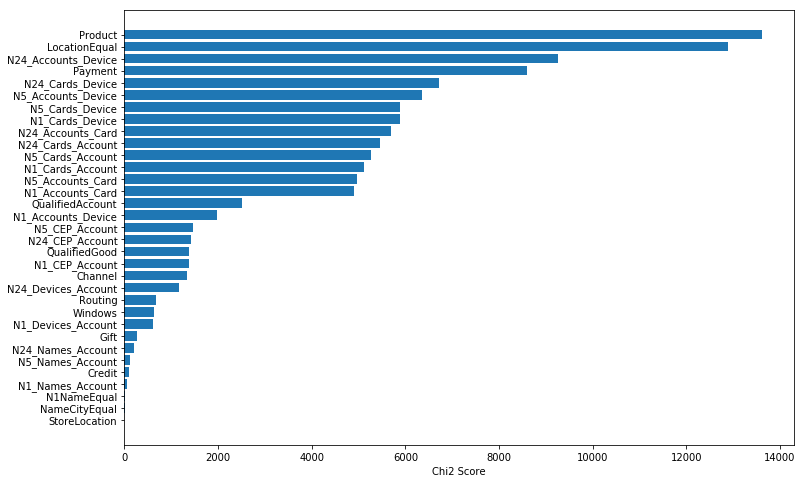

In [17]:
from scipy.stats import chi2_contingency

chi2_scores = []

for feature in [f for f in cat_features if f != "Fraud"]:
    contingency = fraud_data.groupby([feature, "Fraud"]).ID.count()\
        .reset_index()\
        .pivot_table(
            index = "Fraud", values = "ID", columns = feature, fill_value = 0
        )
    score, p_value, _, _ = chi2_contingency(contingency.values)
    chi2_scores.append(score)
    
chi2_scores = pd.DataFrame({
    "feature": cat_features,
    "chi2_score": chi2_scores
}).sort_values("chi2_score")

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(12)
ax.barh( y = chi2_scores["feature"], width = chi2_scores["chi2_score"])
ax.set_xlabel("Chi2 Score")
plt.show()

Como podemos ver, parece que la variable con una distribución más distinta entre fraude/no fraude es la de producto.

Vamos a visualizar algunas distribuciones y conteos para ver como quedan.

In [18]:
def plot_cat_feature(fraud_data, feature):
    """ Plotea un gráfico con la frecuencia de fraude por clase y otro con
    el conteo de muestras en una clase.
    Args:
        fraud_data (pd.DataFrame): DataFrame con los datos de fraude.
        feature (string): Nombre de la columna a representar.
    """
    fig, (ax, ax2) = plt.subplots(1, 2)

    fig.set_figheight(6)
    fig.set_figwidth(16)


    agg_data = fraud_data.groupby(feature).agg({"Fraud": ["mean", "count"]})
    agg_data.columns = ["fraud_mean", "fraud_count"]

    ax.set_title(feature)
    ax.set_ylabel("Fraud percentage")
    ax.bar(x = agg_data.index, height = agg_data["fraud_mean"], color = "#5499C7", align = "center")

    ax2.set_title(feature)
    ax2.set_ylabel("Count")
    ax2.bar(x = agg_data.index, height = agg_data["fraud_count"], color = "#DC7633", align = "center")

    plt.show()

#### Product

Vamos a visualizar la variable `Product` que es la que mayor score tiene y, por lo tanto, la menos independiente de la variable objetivo `Fraud`.

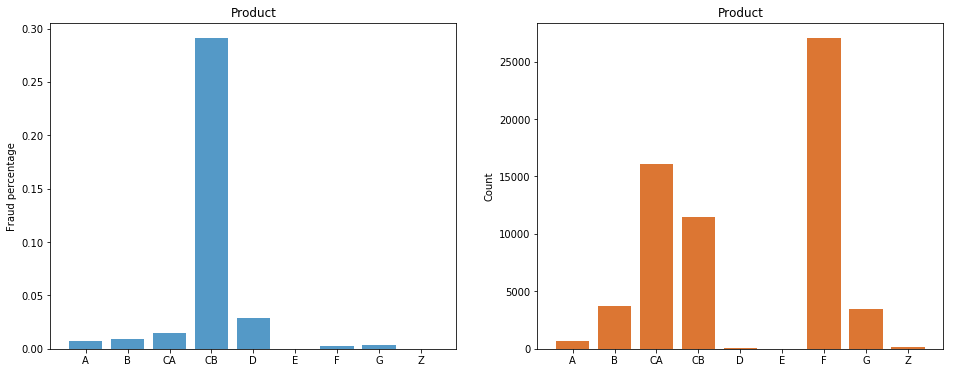

In [19]:
plot_cat_feature(fraud_data, "Product")

Como podemos observar el producto `CB` tiene casi un 30% de casos de fraude, siendo el siguiente producto el `D` con aproximadamente un 4%.

Por lo tanto que una transacción sea con producto `CB` será un gran indicativo de caso de fraude. Tenemos en el dataset 12000 observaciones con este producto por lo que parece ser bastante común.

#### LocationEqual

La siguiente variable en importancia es `LocationEqual`. Vamos a hacer el mismo análisis que con la anterior.

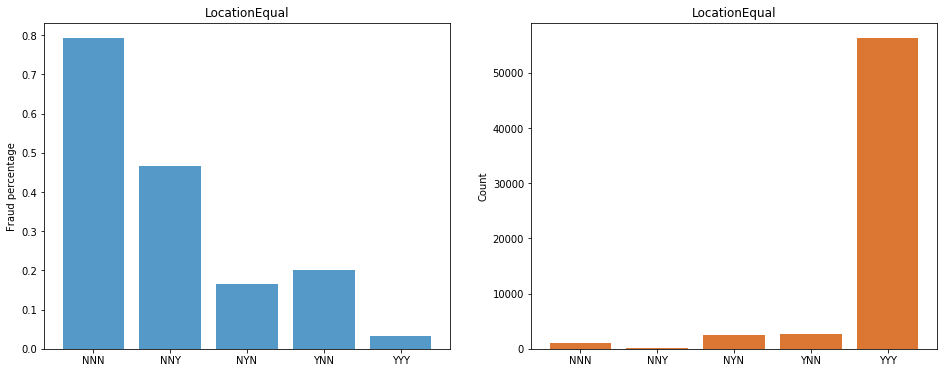

In [20]:
plot_cat_feature(fraud_data, "LocationEqual")

#### StoreLocation

Por último vamos a visualizar `StoreLocation`, la variable con menos score.

Deberíamos ver que el porcentaje de fraude se reparte más uniformemente por todas las clases.

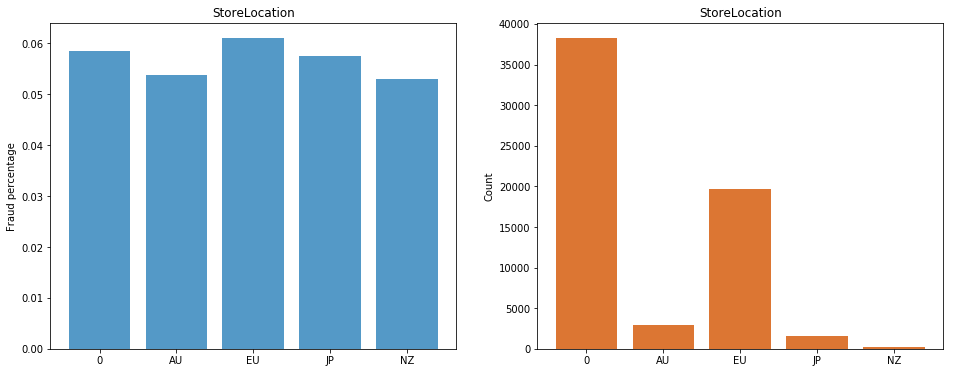

In [21]:
plot_cat_feature(fraud_data, "StoreLocation")

### Variables continuas

Para ver la relación que tienen las variables continuas con la variable objetivo vamos a realizar una Prueba de Kolmogorov-Smirnov entre la distribución de los valores cuando hay fraude y cuando no. Esta prueba comprueba si dos muestras pertenecen a la misma distribución.

Cuando más alto sea el score, menor probabilidad de que la distribución sea igual y por lo tanto más información contiene la variable independiente sobre la variable objetivo.

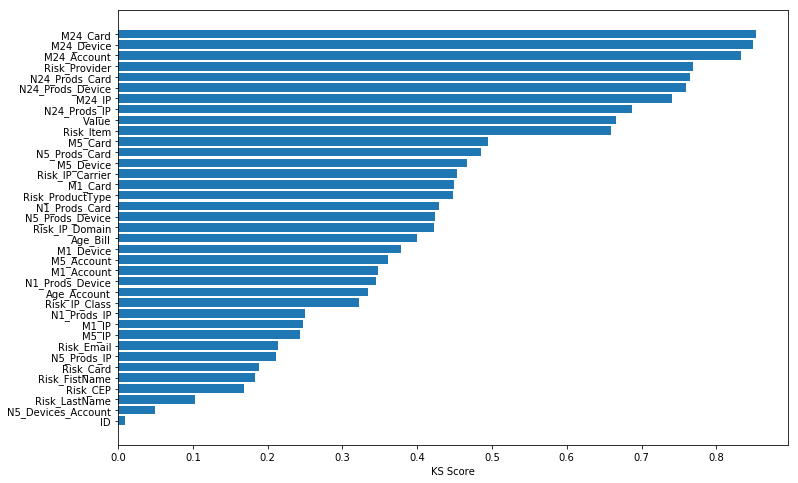

In [22]:
from scipy.stats import ks_2samp

ks_scores = []

for feature in [f for f in num_features if f not in ["Fraud"]]:
    d1 = fraud_data[feature][fraud_data["Fraud"] == 0].values
    d2 = fraud_data[feature][fraud_data["Fraud"] == 1].values
    score, p_value = ks_2samp(d1, d2)
    ks_scores.append(score)
    
    
ks_scores = pd.DataFrame({
    "feature":  [f for f in num_features if f not in ["Fraud"]],
    "ks2_score": ks_scores
}).sort_values("ks2_score")

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(12)
ax.barh( y = ks_scores["feature"], width = ks_scores["ks2_score"])
ax.set_xlabel("KS Score")
plt.show()

Siguiendo el mismo método que con las variables categóricas vamos a intentar visualizar las distribuciones de las que han salido más altas y más bajas.

In [23]:
def plot_density(fraud_data, feature):
    """
    """
    fig, ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(12)
    sns.distplot(
        fraud_data[feature][fraud_data["Fraud"] == 0].values, 
        hist = False, 
        label = "No fraud",
        ax = ax
    )
    sns.distplot(
        fraud_data[feature][fraud_data["Fraud"] == 1].values, 
        hist = False, 
        label = "Fraud",
        ax = ax
    )
    ax.set_ylabel("density")
    ax.set_xlabel(feature)
    plt.show()

#### M24_Account

Como ejemplo de una variable con un score alto tomamos `M24_Account`. Como podemos apreciar en el gráfico, la distribución de transacciones no fraudulentas se concentra en el 0, mientras que las fraudulentas es mucho más dispersa extendiéndose hasta el 25. Está información puede ser incorporado por cualquier modelo y será muy discriminante.

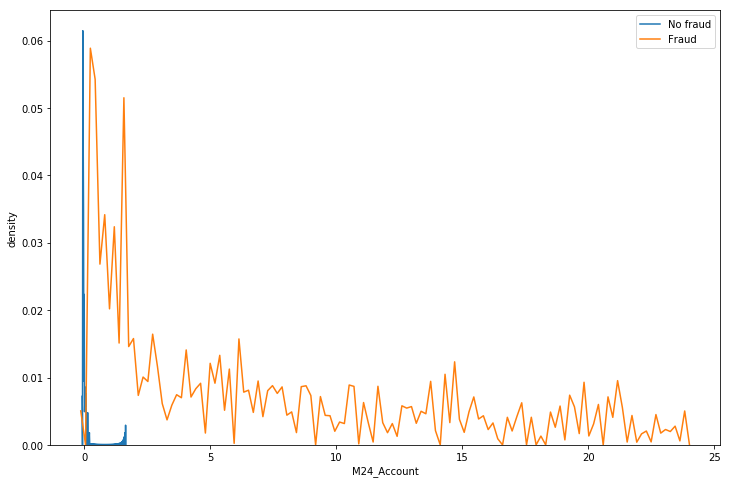

In [24]:
plot_density(fraud_data, "M24_Account")

#### Risk_CEP

Por otro lado, como ejemplo de variable con un score bajo tomamos `Risk_CEP`. Como podemos ver, en este caso las distribuciones son más parecidas, si bien podemos observar una tendencia de las transacciones fraudulentas a tener un valor más alto.

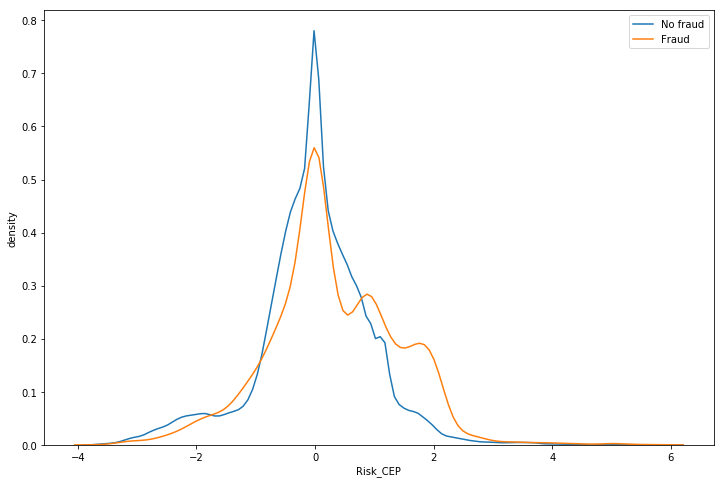

In [25]:
plot_density(fraud_data, "Risk_CEP")

## Modelización

### Divisón en set de entrenamiento y validación

Vamos a dividir el dataset en entrenamiento y validación para el entrenamiento.

En este caso sólo estoy interesado en obtener el mejor modelo posible y no en obtener una estimación no sesgada de la métrica en la realidad, por lo que no vamos a utilizar un set de test independiente.

Por lo tanto las métricas de validación estarán muy probablemente sesgadas a nuestro favor.

De cara a la modelización sólo vamos a considerar como variables categóricas aquellas con `dtype` objeto, considerando el resto de variables categóricas anteriores como variables ordinales y, por tanto, manteniendo su valor. 

In [26]:
cat_features = list(column_description[column_description.dtype == "object"].index)
num_features = [c for c in fraud_data.columns if c not in cat_features]

In [27]:
X = fraud_data.drop(["ID", "Fraud"], axis= 1)
y = fraud_data[["Fraud"]].values

np.random.seed(0)

X_train, X_val, X_train_rf, X_val_rf, y_train, y_val = train_test_split(
    X, pd.get_dummies(X, columns=cat_features), y, test_size = 0.2, 
    stratify = y,
)

### Modelo base

Como modelo base que queremos mejorar vamos a utilizar el propuesto en el notebook EDAv4, un ensemble de arboles de decisión con un PCA previo. Vamos a reproducir los resultados en este notebook para compararlos posteriormente al modelo elegido como mejora.

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score

#### Entrenamiento

Vamos a hacer una pequeña optimización de hiperparámetros para simular como hubiera sido el modelo en la realidad.

In [22]:
np.random.seed(0) # Fijo semilla

# Definición del grid de búsqueda
n_components = [16, 32, 64]
n_estimators = [50, 100, 200]

# Variables del loop
best_auc = 0 # Mejor auc hasta el momento.
rf = None 

# Iteramos para cada número de componentes y numero de estimadores:
for nc in n_components:
    for nest in n_estimators:
        
        # Definición del pipeline de operaciones
        rf_pipe = Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('pca', PCA(n_components=nc)),
            ('random_forest', RandomForestClassifier(n_estimators=nest))
        ]).fit(X_train_rf, y_train)
        
        # Calculo la métrica de validación
        y_pred_val = rf_pipe.predict_proba(X_val_rf)[:, 1]
        auc_val = roc_auc_score(y_val, y_pred_val)
        
        # Almaceno el mejor modelo
        if auc_val > best_auc:
            rf = rf_pipe
            best_auc = auc_val
        
        # Saco resultados por pantalla
        print(f"[n_components {nc}, n_estimators {nest}] AUC val: {auc_val:.4f}")

[n_components 16, n_estimators 50] AUC val: 0.9605
[n_components 16, n_estimators 100] AUC val: 0.9653
[n_components 16, n_estimators 200] AUC val: 0.9663
[n_components 32, n_estimators 50] AUC val: 0.9667
[n_components 32, n_estimators 100] AUC val: 0.9702
[n_components 32, n_estimators 200] AUC val: 0.9705
[n_components 64, n_estimators 50] AUC val: 0.9721
[n_components 64, n_estimators 100] AUC val: 0.9724
[n_components 64, n_estimators 200] AUC val: 0.9737


In [23]:
joblib.dump(rf, "rf.jl")

['rf.jl']

### Modelo red neuronal

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import QuantileTransformer, LabelEncoder
from sklearn.metrics import roc_auc_score

No se cree que un modelo no supervisado mejore el modelo actual con una muestra de fraude del 5%.

Se propone en su lugar una arquitectura sencilla de redes neuronales con una capa de reducción dimensional oculta y una regresión logística en la capa de salida. De esta manera podremos visualizar la reducción dimensional que realiza la red y posiblemente mejorar el modelo anterior sustancialmente.

Adicionalmente, para representar las variables categóricas se utilizarán *embeddings* de baja dimensionalidad para facilitar la visualización de los factores latentes.


#### Arquitectura de la red

In [31]:
class FraudDetector(nn.Module):
    """ Implementa una red neuronal para el problema de detección de fraude.
    Las variables categóricas son mapeadas a embbedings de dimensionalidad dos 
    para hacerlos interpretables.
    Las variables numéricas son escaladas entre 0 y 1 utilizando cuantiles.
    La red devuelve la probabilidad de que una transacción sea fraude.
    """
    
    def __init__(self, emb_dim = 2, hidden = 5):
        """ Constructor del objeto.
        Args:
            emb_dim (int): Número de factores latentes en los embeddings.
            hidden (int): Número de neuronas en la capa oculta.
        """
        super().__init__()
        self.emb_dim = emb_dim
        self.hidden = hidden
        self.activation = nn.Tanh()
    
    def fit(self, X, y, X_val, y_val, n_epoch = 100, lr = 1e-3, refit = False, early_stopping = 100):
        """ Entrena el modelo.
        Args:
            X (pd.DataFrame): Dataframe con las variables independientes para 
                entrenamiento.
            y (np.array): Array con la variable dependiente para entrenamiento.
            X_val(pd.DataFrame): Dataframe con las variables independientes para 
                validación.
            y_val (np.array): Array con la variable dependiente para validación.
            n_epoch (int): Numero de epochs a entrenar.
            lr (float): Learning rate para el optimizador Adam.
            refit (bool): Si queremos continuar el entrenamiento desde un punto.
        """
        
        if not refit: # Si estamos refiteando no volvemos a usar la red.
            self._build_net(X)
        
        self.train() # Indicamos que se ponga en modo entrenamiento.
        
        # Convertimos a tensores los arrays con las etiquetas.
        y_true = torch.FloatTensor(y)
        y_val_true = torch.FloatTensor(y_val)
        
        # Definimos la función de pérdida (binary Xentropy) y el optimizador Adam
        loss_function = nn.BCELoss()
        optimizer = optim.Adam(self.parameters(), lr = lr)
        
        # Creamos listas para ir almacenando las pérdidas
        self.train_losses = []
        self.val_losses = []
        
        # Declaramos variables que vamos a utilizar dentro del loop.
        patience = 0 # Contador de veces que el entrenamiento empeora la red.
        max_auc = None # Maxima auc conseguida hasta el momento.
        best_state = None # Mejor estado de los pesos hasta el momento.
        
        # Hacemos un entrenamiento con el batch completo de datos por facilicidad 
        # de implementación, además al tener pocos datos no creo que tarde mucho
        # en converger.
        for epoch in range(n_epoch):
            
            optimizer.zero_grad() # Pongo los gradientes a cero
            # Calculo la función de pérdida.
            loss_train = loss_function(self(X), y_true)
            # Propago el error hacia atrás calculando los gradientes.
            loss_train.backward()
            optimizer.step() # Hago un paso del optimizador, actualizando los pesos.
            
            y_val_pred = self(X_val) # Predigo los datos de validación
            loss_val = loss_function(y_val_pred, y_val_true) # Calculo pérdida de validación.
            
            # Añade las pérdidas a las listas para almacenarla.
            self.train_losses.append(loss_train.item())
            self.val_losses.append(loss_val.item())
            
            # Calculo el AUC de validación para determinar el early stopping.
            auc_val = roc_auc_score(y_val_true, y_val_pred.detach().numpy())
            
            # Compruebo si el AUC de validación a mejorado en el epoch. Si ha mejorado
            # almaceno el estado y pongo la paciencia a 0. En caso contrario aumento la
            # paciencia.
            if max_auc is None or auc_val > max_auc:
                best_state = self.state_dict()
                max_auc = auc_val
                patience = 0
            else:
                patience += 1
            
            # Saco por pantalla los errores del epoch.
            print(
                f"\r[Epoch {epoch + 1}] Train {loss_train:.4f}" + \
                f"| Val {loss_val:.4f}" + \
                f" AUC {auc_val:.4f} | Patience {patience}", 
                end = ""
            )
            
            # Si la paciencia supera los epoch de early stopping paro el entrenamiento y 
            # cargo el mejor estado.
            if(patience > early_stopping):
                print(f"\nEarly_stopping best auc {max_auc:.4f}.")
                self.load_state_dict(best_state)
                return self
            
        return self
            
    def predict(self, X):
        """ Predice los datos de X.
        Returns:
            Array con las predicciones.
        """
        self.eval()
        return self(X).detach().numpy()
    
    def forward(self, X):
        """ Propaga hacia delante X
        Returns:
            Tensor de pytorch con las etiquetas predichas.
        """
        # La transformación está metida en el loop lo cual no es lo más
        # eficiente del mundo. Habría que cambiarlo si tuviesemos más
        # datos.
        
        # Transformo y convierto a tensor las variables numericas.
        x = self._transform(X)
        x = self.linear_1(x)
        x = self.activation(x)
        x = self.linear_2(x)
        return nn.Sigmoid()(x)
    
    def projection(self, X):
        """ Proyecta los datos sobre la primera capa de la red neuronal.
        Args:
            X (pd.DataFrame): DataFrame con las variables independientes.
        """
        self.eval()
        x = self._transform(X)
        x = self.linear_1(x)
        return self.activation(x).detach().numpy()
    
    def _transform(self, X):
        """ Aplica las transformaciones al data.frame y lo convierte en tensor.
        Args:
            X (pd.DataFrame): DataFrame con las variables independientes.
        Returns:
            FloatTensor con las variables transformadas
        """
        # Normalizo las variables numéricas.
        x_num = torch.FloatTensor(
            self.num_transformer.transform(X[self.num_features])
        )
        # Transformo y paso por los embeddings las variables categoricas
        x_cat = torch.cat([
            getattr(self, feature)(
                torch.LongTensor(
                    self.cat_transformers[feature].transform(X[feature])
                )
            )
            for feature in self.cat_features
        ], dim = 1)
        # Devolvemos el tensor conjunto.
        return torch.cat([x_num, x_cat], dim = 1)
    
    def _build_net(self, data):
        """ Construye la arquitectura de la red neuronal.
        Args:
            data (pd.DataFrame): DataFrame con las variables independientes.
        """
        # Obtengo las varibles categoricas
        self.cat_features = data.columns[data.dtypes == "object"]
        # Construyo el transformador de etiquetas
        self.cat_transformers = {
            feature: LabelEncoder().fit(data[feature])
            for feature in self.cat_features
        }
        # Obtengo las variables numericas
        self.num_features = [c for c in data.columns if c not in cat_features]
        # Construyo el transformador que escala las variables numéricas
        self.num_transformer = QuantileTransformer().fit(
            data[self.num_features]
        )
        # Añado los embeddings
        for feature in cat_features:
            cardinality = data[feature].unique().size
            self.add_module(
                name = feature, 
                module = nn.Embedding(cardinality, self.emb_dim)
            )
        # Construyo la red        
        in_features = self.emb_dim * len(self.cat_features) +\
            len(self.num_features)
        # Primera capa oculta que reduce la dimensionalidad
        self.linear_1 = nn.Linear(in_features, self.hidden)
        # Capa de regresión logistica final
        self.linear_2 = nn.Linear(self.hidden, 1)
        

def plot_training(model):
    """ Pinta la evolución de las pérdidas de entrenamiento y validación
    tras el entrenamiento.
    Args:
        model (FraudModel): Modelo de fraude.
    """
    fig, ax = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(9)
    ax.plot(model.train_losses, label = "train")
    ax.plot(model.val_losses, label = "validation")
    ax.set_xlabel("num epoch")
    ax.set_ylabel("binary cross entropy")
    ax.legend()
    plt.show()

#### Entrenamiento

In [79]:
X = fraud_data.drop(["ID", "Fraud"], axis= 1)
y = fraud_data[["Fraud"]].values

torch.manual_seed(0)
np.random.seed(0)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size = 0.2, stratify = y
)

fd = FraudDetector().fit(
    X_train, y_train, X_val, y_val, n_epoch = 2000, lr = 1e-2, 
    early_stopping = 100
)

[Epoch 813] Train 0.0453| Val 0.0472 AUC 0.9864 | Patience 101
Early_stopping best auc 0.9865.


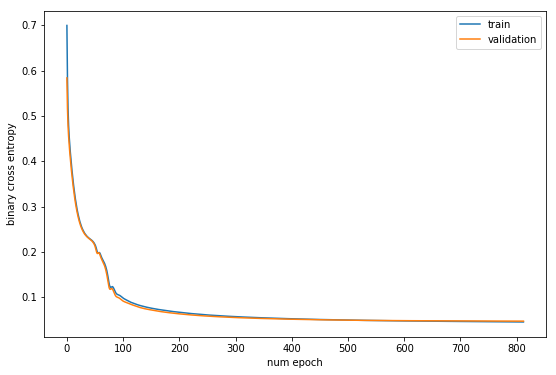

In [82]:
plot_training(fd)

In [83]:
torch.save(fd, "fd.pth")

#### Interpretación

##### Representación factores latentes

Podemos representar los *embeddings* de las variables categóricas que hemos definido.

En una situación donde tuvieramos más información sobre que representa cada una de las variables podríamos sacar conclusiones de las posiciones relativas de cada categoría.

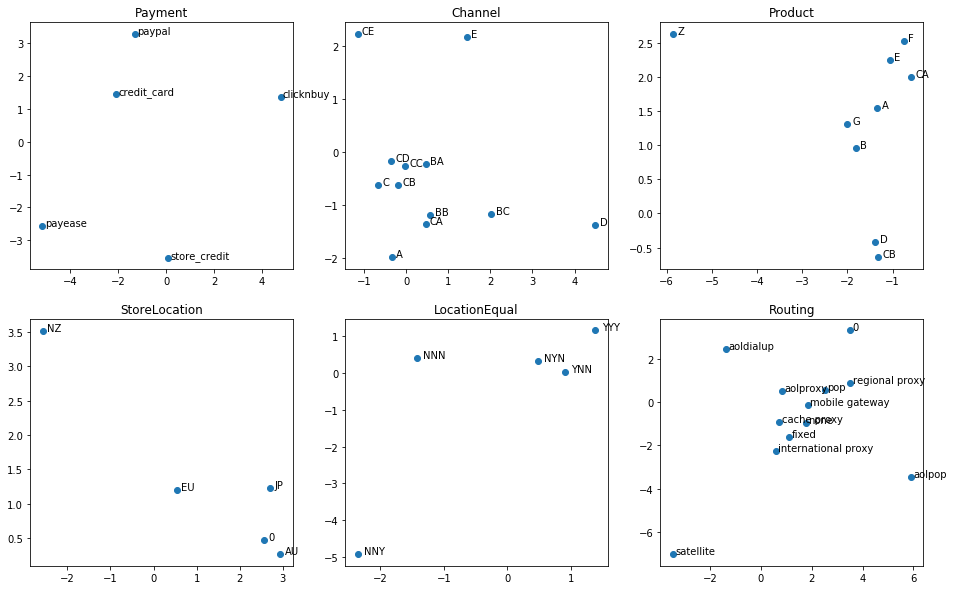

In [85]:
fig, axes = plt.subplots(2, len(fd.cat_features) // 2)

fig.set_figheight(10)
fig.set_figwidth(16)

for feature, ax in zip(fd.cat_features, axes.flatten()):

    X = getattr(fd, feature)._parameters['weight'].detach().numpy()
    txt = list(fd.cat_transformers[feature].classes_)
    
    ax.set_title(feature)
    ax.scatter(x = X[:, 0], y = X[:, 1])

    for i in range(X.shape[0]):
        ax.text(x = X[i, 0] + 0.1, y = X[i, 1], s = txt[i])

plt.show()

##### Proyección de la capa oculta

Así mismo, podemos representar la proyección de las variables en la capa oculta, que realiza algo así como una reducción dimensional supervisada.

Como podemos observar en los gráficos de la diagonal principal las distribuciones de cada variable entre fraude/no fraude son muy discriminantes.

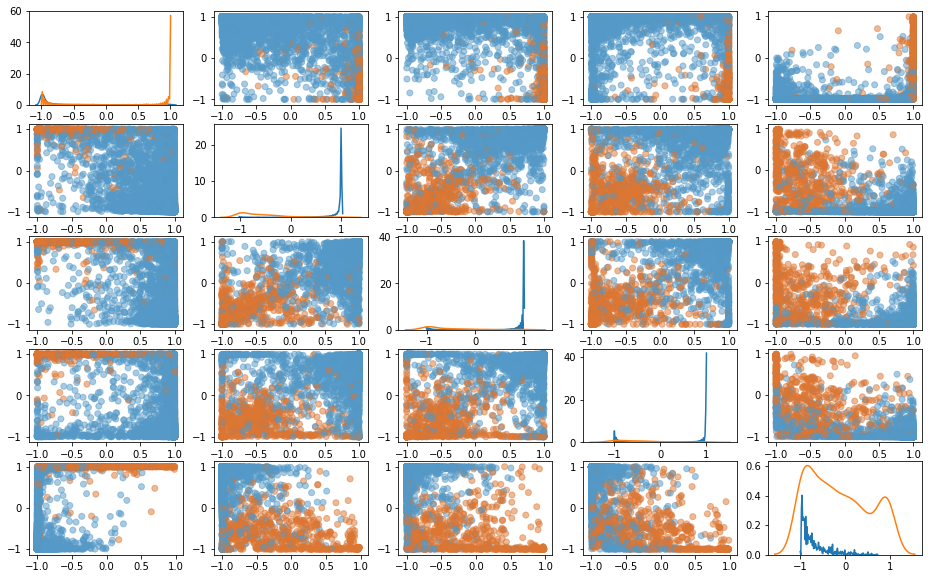

In [93]:
prj = fd.projection(X_val)

fig, ax = plt.subplots(fd.hidden, fd.hidden)

fig.set_figheight(10)
fig.set_figwidth(16)

for i in range(fd.hidden):
    for j in range(fd.hidden):
        
        if i == j:
            x = prj[:, i]
            sns.distplot(x[y_val.squeeze() == 0], hist = False, ax = ax[i, j])
            sns.distplot(x[y_val.squeeze() == 1], hist = False, ax = ax[i, j])
        else:
            ax[i,j].scatter(
                prj[:, i], prj[:, j],
                alpha = 0.5, 
                color = ["#DC7633" if yi == 1 else "#5499C7" for yi in y_val]
            )

plt.show()

##### Importancia variables

Cómo tenemos un modelo que no calcula la importancia de variables de por sí vamos a utilizar un método independiente del modelo para estimar su importancia: *Permutation Feature Importance*.

Este método se basa en ir permutando cada una de las variables del set de validación y calcular cómo disminuye la métrica. Las variables que hagan que la métrica disminuya mucho, serán las más importantes ya que son las más sensibles a un cambio.

In [30]:
np.random.seed(0)

repetitions = 5

base_auc = roc_auc_score(y_val, fd.predict(X_val))

diff_auc = []
diff_auc_sd = []

for feature in X_val.columns:
    X_perm = X_val.copy()
    f_aucs = []
    for _ in range(5):
        X_perm[feature] = np.random.permutation(X_val[feature])
        y_pred = fd.predict(X_perm)
        f_aucs.append(roc_auc_score(y_val, y_pred))
    f_aucs = base_auc - np.array(f_aucs)
    diff_auc.append(f_aucs.mean())
    diff_auc_sd.append(f_aucs.std())

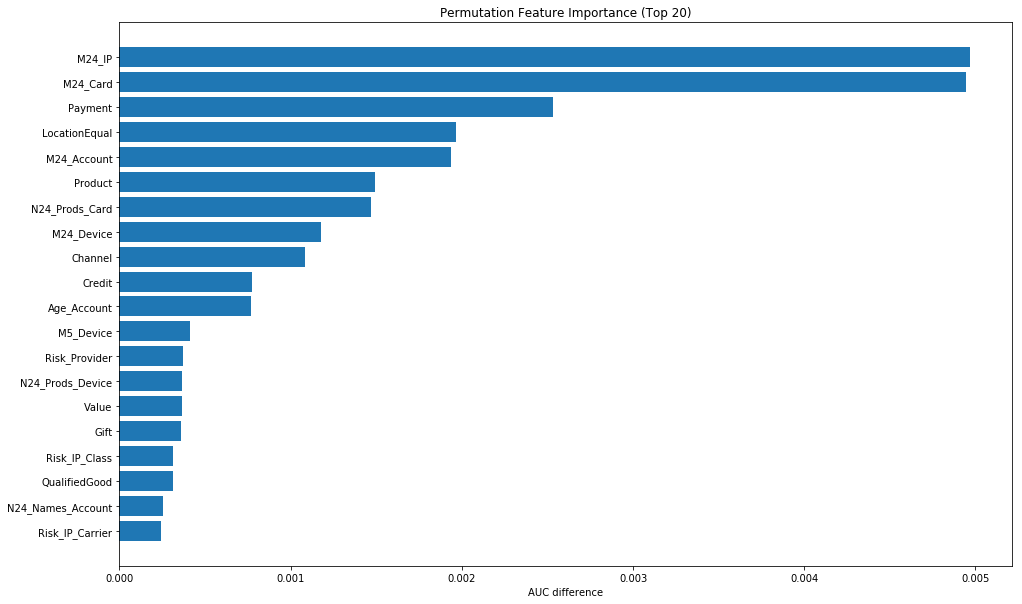

In [31]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)
importance = pd.DataFrame({
    "importance": diff_auc,
    "feature": X_val.columns
}).sort_values("importance").tail(20)
ax.barh( y = importance["feature"], width = importance["importance"])
ax.set_title("Permutation Feature Importance (Top 20)")
ax.set_xlabel("AUC difference")
plt.show()

Como podemos ver, muchas de las variables que salen importantes para el modelo son aquellas que hemos encontrado que tenían distribuciones distintas entre fraude/no fraude. 

El valor que introduce la importancia de variables del modelo es que se tiene en cuenta la interacción entre las mismas, de ahí el cambio de posiciones de importancia.

### Optimización de la frontera de decisión

Según el planteamiento del problema tenemos que:

* El coste de analizar una operación de forma manual para evaluar su fraudulencia es de 3 horas, con un coste del técnico de análisis de 35 euros la hora.

* El coste de no reportar una operación fraudulenta a los organismos pertinentes es una multa de 10.000 euros y la probabilidad de ser multados es de un 2%.

Suponemos que los análisis manuales son infalibles a la hora de detectar fraude.

Por lo tanto:

* El coste de etiquetar una transacción como fraudulenta manualmente es de 105€.
* El coste de un falso negativo es de 200€, teniendo en cuenta la esperanza de ser multado.

Si revisasemos todas las transacciones manualmente, el coste unitario por transacción sería 105€.

Generalizando, la esperanza de coste será:
    
Si no revisasemos nada manualmente el coste esperado, suponiendo que modelizamos la probabilidad:

$E(C) = P(y=1) \cdot P_{multa} \cdot C_{multa}$

Nos saldría rentable comprobar a mano aquellas transacciones donde:

$P(y=1) \cdot P_{multa} \cdot C_{multa} \geq C_{revision}$

Por lo tanto la frontera teórica sería aquella que cumpliese:

$P(y=1) \geq \frac{C_{rev}}{P_{multa} \cdot C_{multa}}$

Particularizando para nuestro caso la frontera teórica, asumiendo que modelizamos perfectamente la probabilidad sería de 0.525.

Cómo no lo hacemos, vamos a optimizar este *threshold* con los datos reales, teniendo en cuenta que debería salir algo parecida.

In [34]:
fd = torch.load("fd.pth")
rf = joblib.load("rf.jl")

In [81]:
def compute_unit_cost(y_val_pred, y_val, C_rev, P_mul, C_mul, th):
    """ Calcula el coste unitario por transacción.
    Args:
        y_val_pred (np.array): Array con las probabilidades de fraude.
        y_val (np.array): Array con el ground truth.
        C_rev (float): Coste de la revisión manual.
        P_mul (float): Probabilidad de ser multado si no se reporta una operación.
        C_mul (float): Cuantía de la multa.
        th (float): Frontera de decisión.
    Returns:
        float, coste unitario de transacción.
    """
    pos = ((y_val_pred >= th) * 1).sum() * C_rev
    neg = y_val[y_val_pred < th].sum() * P_mul * C_mul
    return (pos + neg) / len(y_val)

In [137]:
y_val_pred_fd = fd.predict(X_val)
y_val_pred_rf = rf.predict_proba(X_val_rf)[:, 1]
y_val_pred_dummy = np.zeros(len(y_val))

Vamos calculando el coste probando con distintas fronteras de decisión y nos quedamos con la óptima, tanto para el modelo random forest como para el modelo de redes neuronales.

In [139]:
cost_rf = []
cost_fd = []
cost_dummy = []
ths = np.linspace(0.1, 1, num=100)

for th in ths:
    cost_fd.append(compute_unit_cost(y_val_pred_fd, y_val, 105, 0.02, 10000, th))
    cost_rf.append(compute_unit_cost(y_val_pred_rf, y_val, 105, 0.02, 10000, th))
    cost_dummy.append(compute_unit_cost(y_val_pred_dummy, y_val, 105, 0.02, 10000, th))
    
cost_rf = np.array(cost_rf)
cost_fd = np.array(cost_fd)
cost_dummy = np.array(cost_dummy)


th_rf = ths[np.argmin(cost_rf)]

th_fd = ths[np.argmin(cost_fd)]

Vamos a visualizar cual sería el coste unitario de transacción para ambos modelos en función de el *threshold*. 

Además introducimos qué pasaría si siempre dijesemos que la transacción es no fraudulenta con un modelo *dummy*.

Cabe resaltar que estos datos están sesgados a nuestro favor ya que estamos seleccionando modelos y fronteras en función de los mismos.

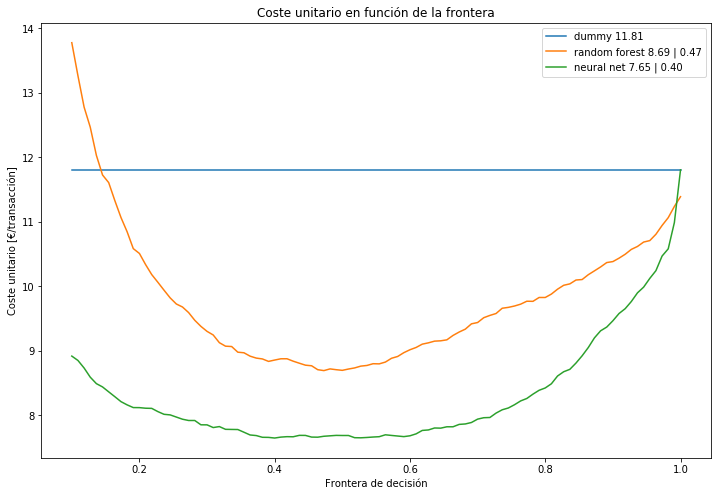

In [144]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(12)
ax.plot(ths, cost_dummy, label = f"dummy {np.min(cost_dummy):.2f}")
ax.plot(ths, cost_rf, label = f"random forest {np.min(cost_rf):.2f} | {th_rf:.2f}")
ax.plot(ths, cost_fd, label = f"neural net {np.min(cost_fd):.2f} | {th_fd:.2f}")
ax.set_xlabel("Frontera de decisión")
ax.set_ylabel("Coste unitario [€/transacción]")
ax.set_title("Coste unitario en función de la frontera")
ax.legend()
plt.show()

In [135]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(ax, y_val_pred, y_val, th, title = ""):
    """ Plotea una matriz de confusión.
    Args:
        ax (Axis): Eje de plt en el que se pinta.
        y_val_pred (np.array): Array con las probabilidades de fraude.
        y_val (np.array): Array con el ground truth.
        th (float): Threshold.
        title (string): Título del gráfico.
    """
    cm = confusion_matrix(1 * (y_val_pred > th), y_val) 
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i, j]:.3f}", ha="center", va="center")
    ax.set(
        xticks=np.arange(2),
        yticks=np.arange(2),
        title = title,
        xticklabels=["No fraud", "Fraud"], yticklabels=["No fraud", "Fraud"],
        ylabel="True label",
        xlabel="Predicted label"
    )

Por último visualizamos las matrices de confusión para cada modelo:

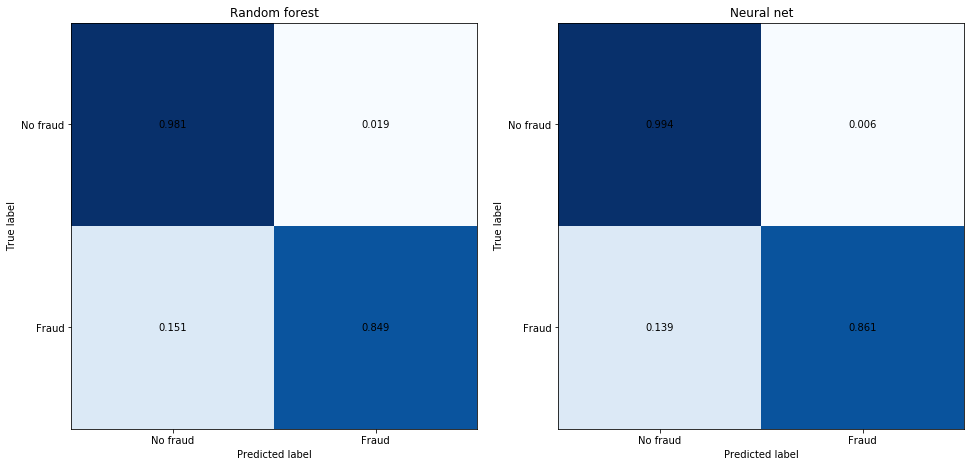

In [134]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(8)
fig.set_figwidth(16)

plot_confusion_matrix(ax1, y_val_pred_rf, y_val, th_rf, title = "Random forest")
plot_confusion_matrix(ax2, y_val_pred_fd, y_val, th_fd, title = "Neural net")
